<h3>Exploring venues in Hi-tech city Hyderabad, India

Table of Contents<br>
    -Introduction<br>
    -Data Collection from APIs<br>
    -Data Cleaning

<h4>Introduction

The aim of the project is to identify venues in Hi-Tech city Hyderabad, India based on their rating and average prices. In this notebook, Identifies various venues in the Hi-Tech city of Hyderabad, India, using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

<h4>Data Collection from APIs

To begin with, we will take a look at Hi-Tech city Hyderabad on the Map using the folium library.

also fetch the data from two different APIs.

Foursquare API: Using Foursquare API fetching venues in Hi-Tech city starting from the middle upto 4 Kilometers in each direction.
Zomato API: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

In [60]:
HYD_LAT = '17.4435' #'17.3850' 
HYD_LON = '78.3772' #'78.4867'
print('Hyderabad geo cordinates are:')
print('LAT: ', HYD_LAT)
print('LON: ', HYD_LON)

Hyderabad geo cordinates are:
LAT:  17.4435
LON:  78.3772


Using folium library to create a complete map zoomed of Hi-Tech city Hyderabad. This will give a relatively good look at the center point for visualizing.

In [61]:
import folium
HYD_MAP = folium.Map(location = [HYD_LAT,HYD_LON], zoom_start = 10)
HYD_MAP

<h3>Foursquare API<br>
<h6>Fetching all the venues in Hi-Tech city with in a range of 4kms using Foresquare API.<br>
The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates.

In [62]:
FS_C_ID = 'H0E0VQQFYSRO3JPTUJ1EV5N4KKEDZ5FETQSEJXAGWKP2TFCZ'
FS_C_S = 'EG0VMHRRE5V2CSVYTXFBIIY0KUDSZTUQSD4DENVZUMCZG4CN'
RADIUS = 4000 #4KMS
NO_OF_VENUES = 100
VERSION = '20191210'

Defining the get_category_type method to get the correct category for each venue.

In [63]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return none
    else:
        return categories_list[0]['name']

<h5>
-Using API fetching all the venues with in the given distance. Maximum of 100 venues can be fetched using API.<br>
-Foursquare API requires client_id, and client_secret for authentication developer account.<br>
-Version parameter is used to fetch the data of the current date 

In [64]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests 


pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FS_C_ID, 
                                                                        FS_C_S, 
                                                                        VERSION, 
                                                                        HYD_LAT, 
                                                                        HYD_LON, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))


Total 100 venues fetched within a total radius of 4.0 Km
Total 4 venues fetched within a total radius of 4.0 Km

Total 104 venues fetched


Zomato API<br>
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query,<br> 
latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.<br>

-Using name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.<br>
-The query will be the name of the venue.<br>
-The start defines from what offset to be start, so initially keep it to 0.<br>
-The count defines the number of restaurants to be fetched.<br>
-Passing latitude and longitude values.<br>
-Setting sorting criteria as real_distance so each time the venue which is searched based on location coordinates.<br>

In [65]:
headers = {'user-key': 'b3a1c26ed20422bfaae7ada558744e1f'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

Data Cleaning<br>
-The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.<br>
-Plotting Foursquare data on the map.

In [66]:
HYD_MAP = folium.Map(location = [HYD_LAT, HYD_LON], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(HYD_MAP)  

HYD_MAP.save('Foursquare.html')
HYD_MAP

Plotting Zomato data.

In [67]:
HYD_MAP = folium.Map(location = [HYD_LAT, HYD_LON], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(HYD_MAP)  

HYD_MAP.save('Zomato.html')
HYD_MAP

To combine the two datasets, rounding both the latitude and longitude values upto 4 decimal places and calculating
the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 
which should ideally mean that the two locations are same.

In [68]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [69]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [71]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Kangan,Indian Restaurant,17.4422,78.3813,Seasonal Tastes - The Westin,17.4420,78.3810,3000.0,4.0,4.4,"The Westin, Mindspace IT Park, Hitech City, Hy...",-0.0002,-0.0003
1,Starbucks,Coffee Shop,17.4481,78.3788,Starbucks Coffee,17.4480,78.3788,700.0,2.0,4.2,"Upper Ground Floor, Phoenix Tower A, Opposite ...",-0.0001,0.0000
2,Firewater,Restaurant,17.4482,78.3787,Firewater Kitchen & Bar,17.4481,78.3790,1300.0,3.0,4.2,"5th Floor, Phoenix Tower A, Opposite Trident H...",-0.0001,0.0003
3,Karachi Bakery,Bakery,17.4453,78.3859,Karachi Bakery,17.4451,78.3857,300.0,1.0,4.4,"Shop 05, SBR CV Towers, Plot 2, HUDA Techno En...",-0.0002,-0.0002
4,Rubaiyat,Indian Restaurant,17.4449,78.3771,Ohri's Nautanki Gali,17.4447,78.3770,1100.0,3.0,4.5,"Plot 9, Survey 64, Cyber Pearl, Madhapur, Hite...",-0.0002,-0.0001
5,Avasa Hotel,Hotel,17.4471,78.3840,Pi - Hotel Avasa,17.4472,78.3842,2000.0,4.0,4.1,"Hotel Avasa, Survey 64, Sector 1, HUDA Techno ...",0.0001,0.0002
6,Inorbit Mall,Shopping Mall,17.4336,78.3862,Smaaash,17.4337,78.3864,1300.0,3.0,4.3,"5th Floor, Inorbit Mall, Hitech City, Hyderabad",0.0001,0.0002
7,Cream Stone Creations,Ice Cream Shop,17.4342,78.3868,Fusion 9,17.4340,78.3866,1800.0,3.0,4.3,"5th Floor, Inorbit Mall, Hitech City, Hyderabad",-0.0002,-0.0002
8,Amara -The Trident,Restaurant,17.4491,78.3790,Mandil,17.4490,78.3794,650.0,2.0,4.3,"1-90/7/B/22, 8, 9 Cyber Enclave, Opposite Trid...",-0.0001,0.0004
9,Sweet Basket,Dessert Shop,17.4338,78.3691,Sweet Basket,17.4338,78.3691,200.0,1.0,4.1,"Plot 104, Telecom Nagar, Gachibowli, Hyderabad",0.0000,0.0000


In [72]:
selected_venues = selected_venues.drop([0, 20, 25, 29, 32, 34, 47, 49, 56, 57, 58, 59, 60, 64]).reset_index(drop = True)

In [73]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [74]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 59


In [75]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Coffee Shop,Starbucks Coffee,17.4480,78.3788,2.0,4.2,"Upper Ground Floor, Phoenix Tower A, Opposite ...",350.0
1,Restaurant,Firewater Kitchen & Bar,17.4481,78.3790,3.0,4.2,"5th Floor, Phoenix Tower A, Opposite Trident H...",650.0
2,Bakery,Karachi Bakery,17.4451,78.3857,1.0,4.4,"Shop 05, SBR CV Towers, Plot 2, HUDA Techno En...",150.0
3,Indian Restaurant,Ohri's Nautanki Gali,17.4447,78.3770,3.0,4.5,"Plot 9, Survey 64, Cyber Pearl, Madhapur, Hite...",550.0
4,Hotel,Pi - Hotel Avasa,17.4472,78.3842,4.0,4.1,"Hotel Avasa, Survey 64, Sector 1, HUDA Techno ...",1000.0


Analysis 

<BarContainer object of 28 artists>

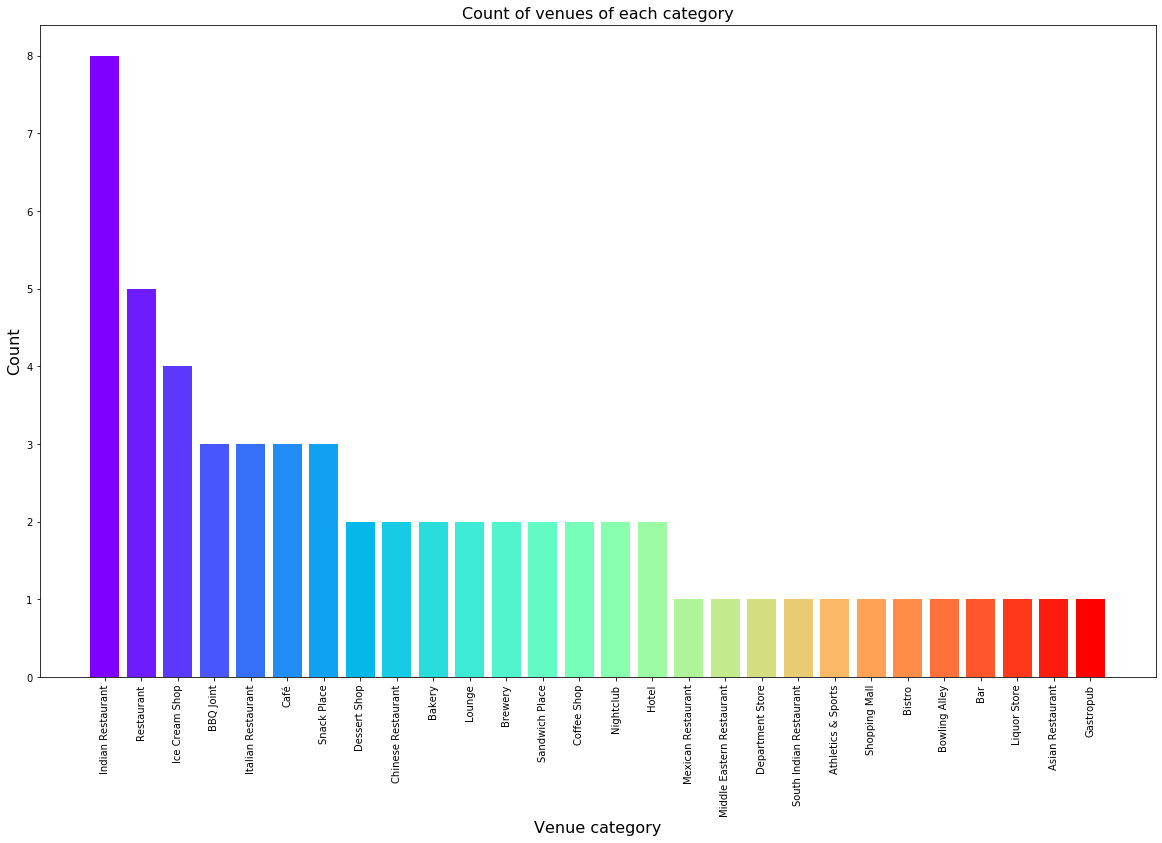

In [76]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

Rating

Text(0.5, 1.0, 'Count of venues with given rating')

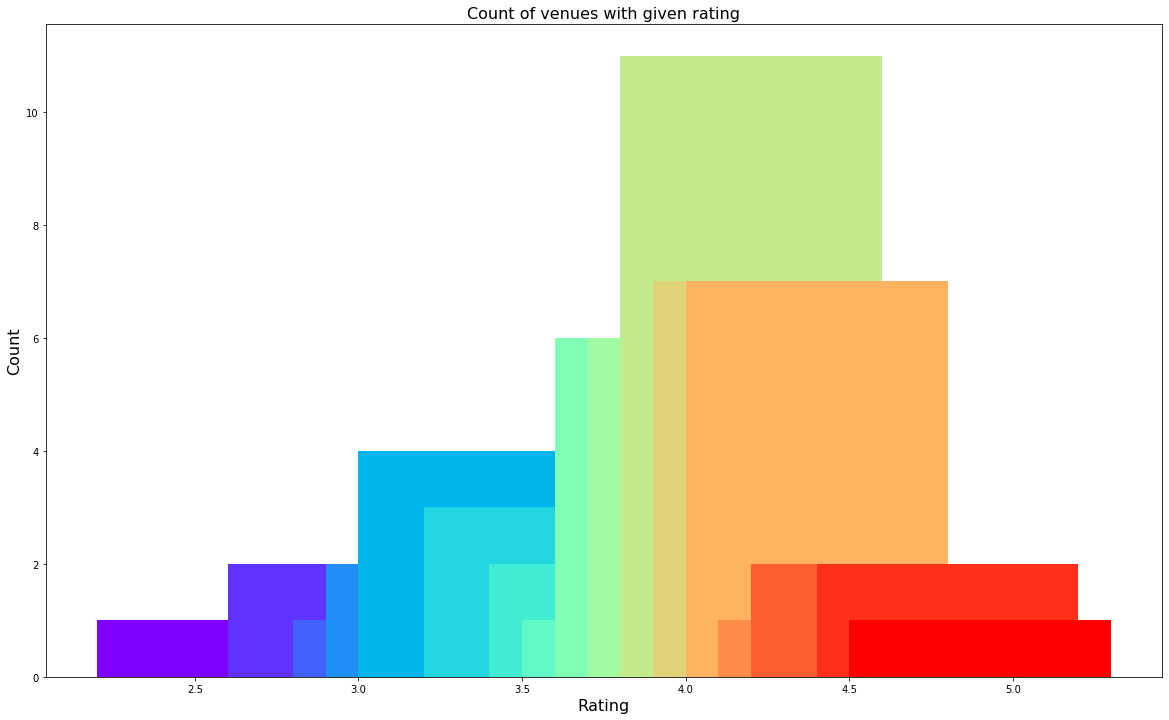

In [77]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

In [78]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [79]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

HYD_MAP = folium.Map(location = [HYD_LAT, HYD_LON], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(HYD_MAP)  

HYD_MAP.save('Ratings.html')
HYD_MAP

Exploring the average_price using a scatter plot between the price and the count of venues.

Text(0.5, 1.0, 'Count of venues with given average price')

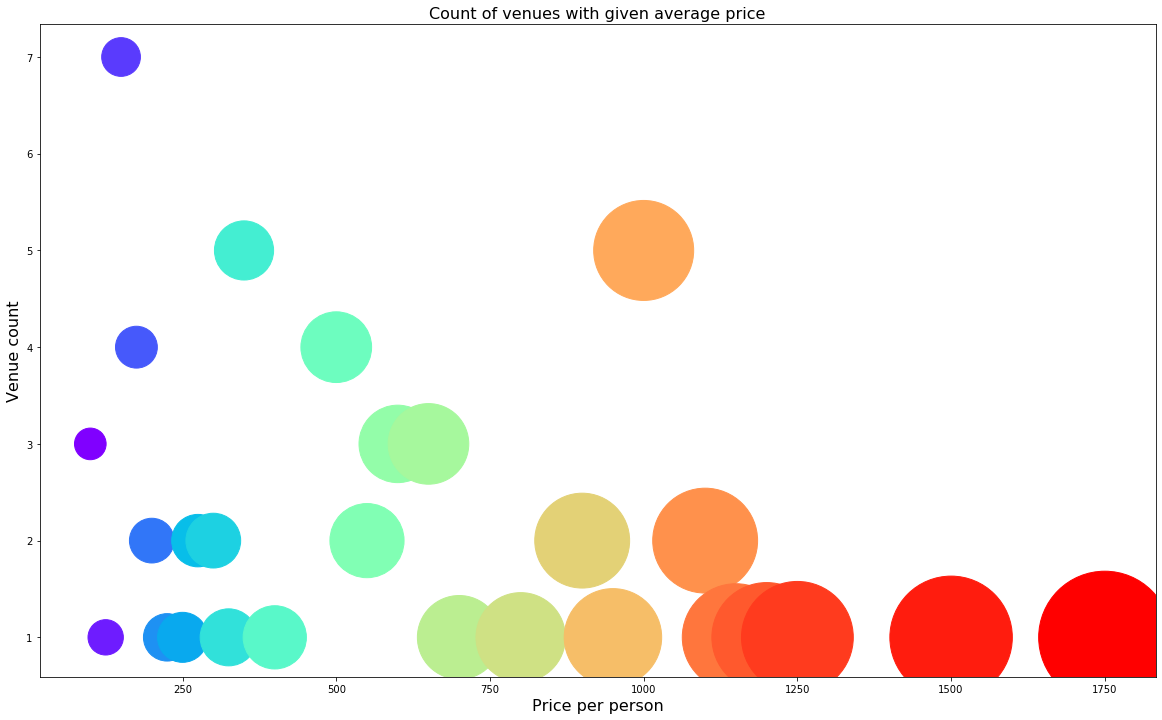

In [80]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

Users might also be interested in going to a place that fits in their budget. 
Using the price_range column to plot the venues on a map and also representing the venues with lower price in green and move towards red as the price increases.

In [81]:

color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

HYD_MAP = folium.Map(location = [HYD_LAT, HYD_LON], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(HYD_MAP)  

HYD_MAP.save('Prices.html')
HYD_MAP

Clustering
Clustering all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. 
Clustering the venues into two separate groups.

In [82]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Coffee Shop,Starbucks Coffee,17.4480,78.3788,2.0,4.2,"Upper Ground Floor, Phoenix Tower A, Opposite ...",350.0,Very good
1,0,Restaurant,Firewater Kitchen & Bar,17.4481,78.3790,3.0,4.2,"5th Floor, Phoenix Tower A, Opposite Trident H...",650.0,Very good
2,0,Bakery,Karachi Bakery,17.4451,78.3857,1.0,4.4,"Shop 05, SBR CV Towers, Plot 2, HUDA Techno En...",150.0,Very good
3,0,Indian Restaurant,Ohri's Nautanki Gali,17.4447,78.3770,3.0,4.5,"Plot 9, Survey 64, Cyber Pearl, Madhapur, Hite...",550.0,Very good
4,1,Hotel,Pi - Hotel Avasa,17.4472,78.3842,4.0,4.1,"Hotel Avasa, Survey 64, Sector 1, HUDA Techno ...",1000.0,Very good


In [83]:
HYD_MAP = folium.Map(location = [HYD_LAT, HYD_LON], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(HYD_MAP)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(HYD_MAP)

HYD_MAP.save('Clusters.html')
HYD_MAP

In [84]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)


Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Coffee Shop,Starbucks Coffee,17.4480,78.3788,2.0,4.2,"Upper Ground Floor, Phoenix Tower A, Opposite ...",350.0,Very good
1,0,Restaurant,Firewater Kitchen & Bar,17.4481,78.3790,3.0,4.2,"5th Floor, Phoenix Tower A, Opposite Trident H...",650.0,Very good
2,0,Bakery,Karachi Bakery,17.4451,78.3857,1.0,4.4,"Shop 05, SBR CV Towers, Plot 2, HUDA Techno En...",150.0,Very good
3,0,Indian Restaurant,Ohri's Nautanki Gali,17.4447,78.3770,3.0,4.5,"Plot 9, Survey 64, Cyber Pearl, Madhapur, Hite...",550.0,Very good
4,0,Shopping Mall,Smaaash,17.4337,78.3864,3.0,4.3,"5th Floor, Inorbit Mall, Hitech City, Hyderabad",650.0,Very good
5,0,Restaurant,Mandil,17.4490,78.3794,2.0,4.3,"1-90/7/B/22, 8, 9 Cyber Enclave, Opposite Trid...",325.0,Very good
6,0,Dessert Shop,Sweet Basket,17.4338,78.3691,1.0,4.1,"Plot 104, Telecom Nagar, Gachibowli, Hyderabad",100.0,Very good
7,0,BBQ Joint,AB's - Absolute Barbecues,17.4430,78.3574,3.0,4.9,"Second Floor, Apurupa Silpi, Indiranagar, Gach...",600.0,Very good
8,0,Nightclub,Heart Cup Coffee,17.4599,78.3685,3.0,4.2,"B 7 & 8, Jubilee Garden, Behind TCS Building, ...",650.0,Very good
9,0,Indian Restaurant,13 Dhaba,17.4375,78.3657,1.0,4.1,"1-72/3A, Andhra Bank Lane, Near H.P. Petrol Pu...",225.0,Very good


In [85]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.88 and rating spread around 3.94


In [86]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Pi - Hotel Avasa,17.4472,78.3842,4.0,4.1,"Hotel Avasa, Survey 64, Sector 1, HUDA Techno ...",1000.0,Very good
1,1,Ice Cream Shop,Fusion 9,17.4340,78.3866,3.0,4.3,"5th Floor, Inorbit Mall, Hitech City, Hyderabad",900.0,Very good
2,1,Asian Restaurant,Seasonal Tastes - The Westin,17.4420,78.3810,4.0,4.4,"The Westin, Mindspace IT Park, Hitech City, Hy...",1500.0,Very good
3,1,Gastropub,The Sky Lounge - Hotel Avasa,17.4473,78.3843,4.0,4.2,"Hotel Avasa, Survey 64, Sector 1, HUDA Techno ...",1000.0,Very good
4,1,Middle Eastern Restaurant,Olive Bistro,17.4294,78.3926,4.0,4.4,"Road 46, Inside Durgam Cheruvu, Jubilee Hills,...",1000.0,Very good
5,1,Lounge,Over The Moon,17.4368,78.3981,4.0,4.4,"Hotel Daspalla, Rooftop, Road 37, Jubilee Hill...",1250.0,Very good
6,1,Italian Restaurant,Prego - The Westin,17.4420,78.3811,4.0,4.2,"The Westin, Mindspace IT Park, Hitech City, Hy...",1750.0,Very good
7,1,Lounge,Fusion 9,17.4340,78.3866,3.0,4.3,"5th Floor, Inorbit Mall, Hitech City, Hyderabad",900.0,Very good
8,1,Chinese Restaurant,Pi - Hotel Avasa,17.4472,78.3842,4.0,4.1,"Hotel Avasa, Survey 64, Sector 1, HUDA Techno ...",1000.0,Very good
9,1,Brewery,Over The Moon Brew Company,17.4402,78.3620,3.0,4.6,"Plot B 2, Survey 6/1, Quiet Lands, Gachibowli...",950.0,Very good


In [87]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.75 and rating spread around 4.30


<h5>Results and Discussion

Price<br>

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

Based on analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting Hi-Tech city Hyderabad, India.

After collecting data from the Foursquare and Zomato APIs, There are around  100+ different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers.

We identified that from the total set of venues, majority of them were Cafes and Indian Restaurants. 
A visitor who loves Cafes/Indian Restaurants would surely benefit from coming to Hi-tech city.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. 
This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. 

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 200 to Rs 400 for one person. 
However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1200. 

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.57. On the other hand, there are few venues which are high priced and have average rating of 4.30